In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from zipfile import ZipFile
import os
from os.path import basename

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img = cv2.imread('/content/cut input/image2.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [ ]:
def getImage(image, coor):
  return image[coor[1]:coor[1]+coor[3], coor[0]:coor[0]+coor[2]]

def getWordContours(image):
  kernel = np.ones((5,5), np.uint8)
  mask = cv2.erode(image, kernel, iterations = 2)
  ret,thresh = cv2.threshold(mask,90,255,cv2.THRESH_BINARY_INV)
  contours, _ = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
  contours_copy = []
  for c in contours:
    if cv2.contourArea(c) < 100:
      continue
    contours_copy.append(c)
  return contours_copy

def getLetterContours(image):
  contours, _ = cv2.findContours(image, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
  return contours

def flipBit(image):
  copy = np.array(image, copy = True)
  for i in range(len(copy)):
    for j in range(len(copy[i])):
      if copy[i][j] == 255:
        copy[i][j] = 0
      else:
        copy[i][j] = 255
  return copy

In [ ]:
information_coor = [[385, 240, 460, 50], [385, 290, 180, 50], [695, 290, 150, 50], [385, 330, 210, 50], [695, 330, 150, 50], [385, 380, 460, 100], [60, 440, 200, 35]]

In [ ]:
information_image = [None]*7
for i in range(7):
  information_image[i] = getImage(gray, information_coor[i])

In [ ]:
information_contours = [None]*7
for i in range(7):
  information_contours[i] = getWordContours(information_image[i])

In [ ]:
word_bounding_box = [[]for _ in range(7)]
for i in range(7):
  image = np.array(information_image[i], copy = True)
  word_bounding_box[i] = [None]*len(information_contours[i])
  for c in range(len(information_contours[i])):
    word_bounding_box[i][c] = cv2.boundingRect(information_contours[i][c])

In [ ]:
for info in range(len(word_bounding_box)):
  y_mean = 0
  for box in word_bounding_box[info]:
    y_mean += box[1]
  y_mean /= len(word_bounding_box[info])
  word_bounding_box[info] = sorted(word_bounding_box[info],key=lambda x: x[0], reverse = False)
  for i in range(len(word_bounding_box[info])):
    if word_bounding_box[info][i][1] > y_mean:
      word_bounding_box[info].append(word_bounding_box[info][i])
      word_bounding_box[info].pop(i)
      i-=1

In [ ]:
word_image = [[]for _ in range(7)]
word_image_thresh = [[]for _ in range(7)]
word_image_thresh_mask = [[]for _ in range(7)]
for i in range(7):
  image = np.array(information_image[i], copy = True)
  for c in range(len(information_contours[i])):
    word_image[i].append(getImage(information_image[i], word_bounding_box[i][c]))
    word_image_thresh[i].append(getImage(information_image[i], word_bounding_box[i][c]))
    word_image_thresh_mask[i].append(getImage(information_image[i], word_bounding_box[i][c]))

In [ ]:
for i in range(len(word_image_thresh)):
  for j in range(len(word_image_thresh[i])):
    ret,word_image_thresh[i][j] = cv2.threshold(word_image_thresh[i][j],80,255,cv2.THRESH_BINARY_INV)
    ret,word_image_thresh_mask[i][j] = cv2.threshold(word_image_thresh_mask[i][j],80,255,cv2.THRESH_BINARY_INV)

In [ ]:
for i in range(len(word_image_thresh_mask)):
  for j in range(len(word_image_thresh_mask[i])):
    contours = getLetterContours(word_image_thresh_mask[i][j])
    for c in contours:
      cv2.fillPoly(word_image_thresh_mask[i][j], [c], color = 255)

In [ ]:
word_box = []
for i in range(len(word_image_thresh_mask)):
  word_box.append([])
  for j in range(len(word_image_thresh_mask[i])):
    word_box[i].append([])
    kernel_horizontal = np.array([[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0]])
    mask = cv2.filter2D(word_image_thresh_mask[i][j], -1, kernel_horizontal)
    for _ in range(20):
      mask = cv2.filter2D(mask, -1, kernel_horizontal)
    contours = getLetterContours(mask)
    box = [None]*len(contours)
    for c in range(len(contours)):
      box[c] = cv2.boundingRect(contours[c])
    box = sorted(box,key=lambda x: x[0], reverse = False)
    for c in range(len(contours)):
      blank_box = np.zeros((50,50))
      box[c] = getImage(word_image_thresh[i][j], box[c])
      h,w = box[c].shape
      blank_box[int(25-h/2):int(25-h/2)+h, int(25-w/2):int(25-w/2)+w] = box[c][0:h, 0:w]
      np.ones((3,3), np.uint8)
      blank_box = flipBit(blank_box)
      word_box[i][j].append(blank_box)

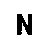

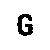

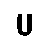

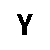

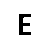

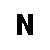

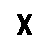

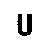

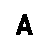

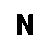

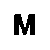

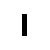

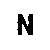

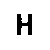

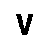

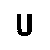

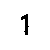

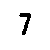

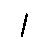

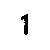

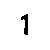

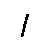

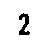

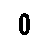

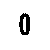

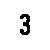

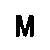

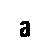

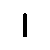

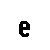

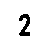

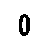

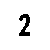

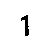

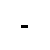

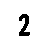

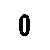

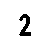

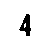

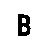

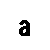

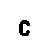

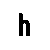

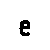

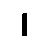

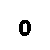

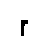

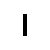

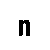

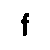

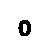

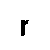

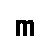

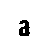

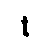

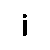

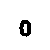

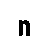

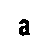

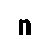

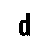

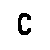

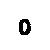

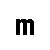

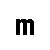

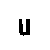

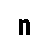

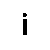

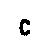

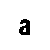

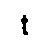

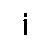

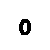

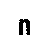

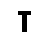

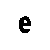

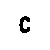

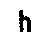

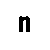

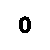

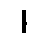

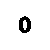

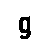

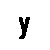

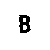

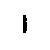

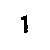

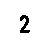

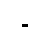

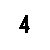

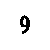

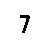

In [ ]:
for i in range(len(word_box)):
  for j in range(len(word_box[i])):
    for k in range(len(word_box[i][j])):
      cv2_imshow(word_box[i][j][k])
    print("\n")